# 📊 Text Cleaning Benchmark for Rakuten Classification

## Objective
Systematically evaluate the **marginal impact** of each text preprocessing step on classification performance.

## Methodology
- **Baseline**: Raw data (no preprocessing)
- **Single-step tests**: Enable only ONE cleaning option at a time
- **Fair comparison**: Same train/test split for all experiments (random_state=42)
- **Simple model**: TF-IDF + LogisticRegression (focus on preprocessing effects)

## Hypothesis
We test whether traditional cleaning steps (HTML removal, lowercasing, stopword removal) actually improve or degrade performance for e-commerce product classification.

## 1. Setup & Imports

In [1]:
# Enable autoreload to pick up code changes without restarting kernel
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rakuten_text.xiaosong_cleaning import clean_text, print_available_options
from rakuten_text.xiaosong_experiments import (
    load_dataset,
    define_experiments,
    run_benchmark,
    analyze_results,
    save_results
)

import warnings
warnings.filterwarnings('ignore')

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 120)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


## 2. Load Dataset

In [3]:
df = load_dataset(data_dir="../data")

# Quick peek at the data
print("\nSample text_raw (first 3 rows):")
print("=" * 80)
for idx in range(min(3, len(df))):
    text = df["text_raw"].iloc[idx]
    print(f"[{idx}] {text[:150]}...")
    print()

Loading Rakuten dataset...
✓ Dataset loaded: 84,916 samples
✓ Columns: ['designation', 'description', 'productid', 'imageid', 'prdtypecode', 'text_raw']
✓ Classes: 27 unique product types
✓ Text_raw created (avg length: 595 chars)


Sample text_raw (first 3 rows):
[0] Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design...

[1] Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des V...

[2] Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour G...



## 3. Inspect Available Cleaning Options

In [4]:
print_available_options()

Available Cleaning Options:
  fix_encoding              : Fix broken text encoding using ftfy
  unescape_html             : Decode HTML entities (&amp; → &)
  normalize_unicode         : Apply Unicode NFC normalization
  remove_html_tags          : Remove HTML tags <tag>content</tag>
  remove_boilerplate        : Remove common template phrases
  lowercase                 : Convert to lowercase
  merge_dimensions          : Merge dimension patterns (22 x 11 → 22x11)
  merge_units               : Merge numeric units (500 g → 500g)
  merge_durations           : Merge durations (24 h → 24h)
  merge_age_ranges          : Merge age ranges (3-5 ans → 3_5ans)
  tag_years                 : Tag 4-digit years (1917 → year1917)
  remove_punctuation        : Remove isolated punctuation marks
  remove_stopwords          : Remove French/English stopwords
  remove_single_letters     : Remove single alphabetic characters
  remove_single_digits      : Remove single numeric digits
  remove_pure_punct_tok

## 4. Define Experiments

In [5]:
experiments = define_experiments()

print(f"Total experiments: {len(experiments)}")
print("\nExperiment groups:")
for group in sorted(set(exp["group"] for exp in experiments)):
    group_exps = [exp["name"] for exp in experiments if exp["group"] == group]
    print(f"  {group}: {len(group_exps)} experiments")
    for exp_name in group_exps:
        print(f"    - {exp_name}")

Total experiments: 22

Experiment groups:
  0_Baseline: 1 experiments
    - baseline_raw
  1_Encoding: 4 experiments
    - fix_encoding
    - unescape_html
    - normalize_unicode
    - all_encoding_fixes
  2_HTML: 2 experiments
    - remove_html_tags
    - remove_boilerplate
  3_Case: 1 experiments
    - lowercase
  4_Merges: 6 experiments
    - merge_dimensions
    - merge_units
    - merge_durations
    - merge_age_ranges
    - tag_years
    - all_merges
  5_Punctuation: 1 experiments
    - remove_punctuation
  6_Filtering: 4 experiments
    - remove_stopwords
    - remove_single_letters
    - remove_single_digits
    - remove_pure_punct_tokens
  7_Combos: 3 experiments
    - traditional_cleaning
    - conservative_cleaning
    - merges_only


## 5. Quick Demo: Test Cleaning Function

In [6]:
# Pick a sample text with HTML and various features
sample_text = df["text_raw"].iloc[10]

print("ORIGINAL:")
print("=" * 80)
print(sample_text[:300])
print("\n")

print("BASELINE (no cleaning):")
print("=" * 80)
print(clean_text(sample_text)[:300])
print("\n")

print("REMOVE HTML TAGS:")
print("=" * 80)
print(clean_text(sample_text, remove_html_tags=True)[:300])
print("\n")

print("LOWERCASE:")
print("=" * 80)
print(clean_text(sample_text, lowercase=True)[:300])
print("\n")

print("TRADITIONAL CLEANING (HTML + lowercase + stopwords):")
print("=" * 80)
print(clean_text(
    sample_text,
    remove_html_tags=True,
    lowercase=True,
    remove_stopwords=True,
    remove_punctuation=True
)[:300])

ORIGINAL:
Eames Inspired Sxw Chair - Pink - Black The timeless DSW seat can now be paired with more types of legs! These wood legs look like a natural fit for the seat and will make a safe choice for any interior. This chair will be perfect  in offices kitchens and dining rooms.  <ul><li><strong>Ideal for :</


BASELINE (no cleaning):
Eames Inspired Sxw Chair - Pink - Black The timeless DSW seat can now be paired with more types of legs! These wood legs look like a natural fit for the seat and will make a safe choice for any interior. This chair will be perfect in offices kitchens and dining rooms. <ul><li><strong>Ideal for :</st


REMOVE HTML TAGS:
Eames Inspired Sxw Chair - Pink - Black The timeless DSW seat can now be paired with more types of legs! These wood legs look like a natural fit for the seat and will make a safe choice for any interior. This chair will be perfect in offices kitchens and dining rooms. Ideal for : kitchen Living room


LOWERCASE:
eames inspired sxw chair - p

## 6. Run Benchmark

⚠️ **Note**: This will take several minutes to complete (~20-30 experiments).

Each experiment:
1. Applies a specific cleaning configuration to all text
2. Trains TF-IDF + LogisticRegression on the same train/test split
3. Evaluates F1 score (weighted) on the test set

In [7]:
# Run the benchmark
results_df = run_benchmark(
    df=df,
    experiments=experiments,
    test_size=0.2,
    random_state=42,
    tfidf_max_features=10000,
    tfidf_ngram_range=(1, 2),
    verbose=True
)

BENCHMARK CONFIGURATION
Total experiments   : 22
Test size           : 0.2
Random state        : 42
TF-IDF max features : 10,000
TF-IDF n-gram range : (1, 2)

Creating train/test split...
  Train: 67,932 samples
  Test : 16,984 samples

[1/22] baseline_raw
  Group : 0_Baseline
  Config: None (raw data)
  Cleaning text... ✓ (avg length: 595 chars)
  Training... ✓
  Evaluating... ✓
  → F1 Score: 0.791929 | Accuracy: 0.7917 | [BASELINE]

[2/22] fix_encoding
  Group : 1_Encoding
  Config: {'fix_encoding': True}
  Cleaning text... ✓ (avg length: 588 chars)
  Training... ✓
  Evaluating... ✓
  → F1 Score: 0.791860 | Accuracy: 0.7916 | Δ vs baseline: 📉 -0.000069 (-0.01%)

[3/22] unescape_html
  Group : 1_Encoding
  Config: {'unescape_html': True}
  Cleaning text... ✓ (avg length: 584 chars)
  Training... ✓
  Evaluating... ✓
  → F1 Score: 0.792376 | Accuracy: 0.7922 | Δ vs baseline: 🚀 +0.000447 (+0.06%)

[4/22] normalize_unicode
  Group : 1_Encoding
  Config: {'normalize_unicode': True}
  Clean

## 7. Results Analysis

In [8]:
analyze_results(results_df, top_n=10)


BENCHMARK RESULTS ANALYSIS

Baseline F1 Score: 0.791929

🚀 TOP 10 IMPROVEMENTS:
--------------------------------------------------------------------------------
  traditional_cleaning           | F1: 0.802396 | Δ: +0.010467 (+1.32%) | Group: 7_Combos
  lowercase                      | F1: 0.797053 | Δ: +0.005124 (+0.65%) | Group: 3_Case
  remove_stopwords               | F1: 0.794934 | Δ: +0.003005 (+0.38%) | Group: 6_Filtering
  merge_dimensions               | F1: 0.793015 | Δ: +0.001086 (+0.14%) | Group: 4_Merges
  remove_html_tags               | F1: 0.792833 | Δ: +0.000904 (+0.11%) | Group: 2_HTML
  all_encoding_fixes             | F1: 0.792779 | Δ: +0.000850 (+0.11%) | Group: 1_Encoding
  merge_durations                | F1: 0.792689 | Δ: +0.000760 (+0.10%) | Group: 4_Merges
  conservative_cleaning          | F1: 0.792576 | Δ: +0.000647 (+0.08%) | Group: 7_Combos
  merge_age_ranges               | F1: 0.792401 | Δ: +0.000472 (+0.06%) | Group: 4_Merges
  unescape_html            

### 7.1 Full Results Table (sorted by F1 score)

In [9]:
# Sort by F1 score descending
results_sorted = results_df.sort_values("f1_weighted", ascending=False).reset_index(drop=True)

# Style the DataFrame
def highlight_delta(val):
    if val > 0.0001:
        return 'background-color: lightgreen'
    elif val < -0.0001:
        return 'background-color: lightcoral'
    else:
        return ''

results_sorted.style.applymap(highlight_delta, subset=['delta_f1', 'delta_pct']).format({
    'f1_weighted': '{:.6f}',
    'accuracy': '{:.4f}',
    'delta_f1': '{:+.6f}',
    'delta_pct': '{:+.2f}%'
})

,experiment,group,f1_weighted,accuracy,delta_f1,delta_pct
0,traditional_cleaning,7_Combos,0.802396,0.8015,+0.010467,+1.32%
1,lowercase,3_Case,0.797053,0.7976,+0.005124,+0.65%
2,remove_stopwords,6_Filtering,0.794934,0.7927,+0.003005,+0.38%
3,merge_dimensions,4_Merges,0.793015,0.7927,+0.001086,+0.14%
4,remove_html_tags,2_HTML,0.792833,0.7925,+0.000904,+0.11%
5,all_encoding_fixes,1_Encoding,0.792779,0.7925,+0.000850,+0.11%
6,merge_durations,4_Merges,0.792689,0.7925,+0.000760,+0.10%
7,conservative_cleaning,7_Combos,0.792576,0.7921,+0.000647,+0.08%
8,merge_age_ranges,4_Merges,0.792401,0.7922,+0.000472,+0.06%
9,unescape_html,1_Encoding,0.792376,0.7922,+0.000447,+0.06%


### 7.2 Visualization: F1 Score by Experiment

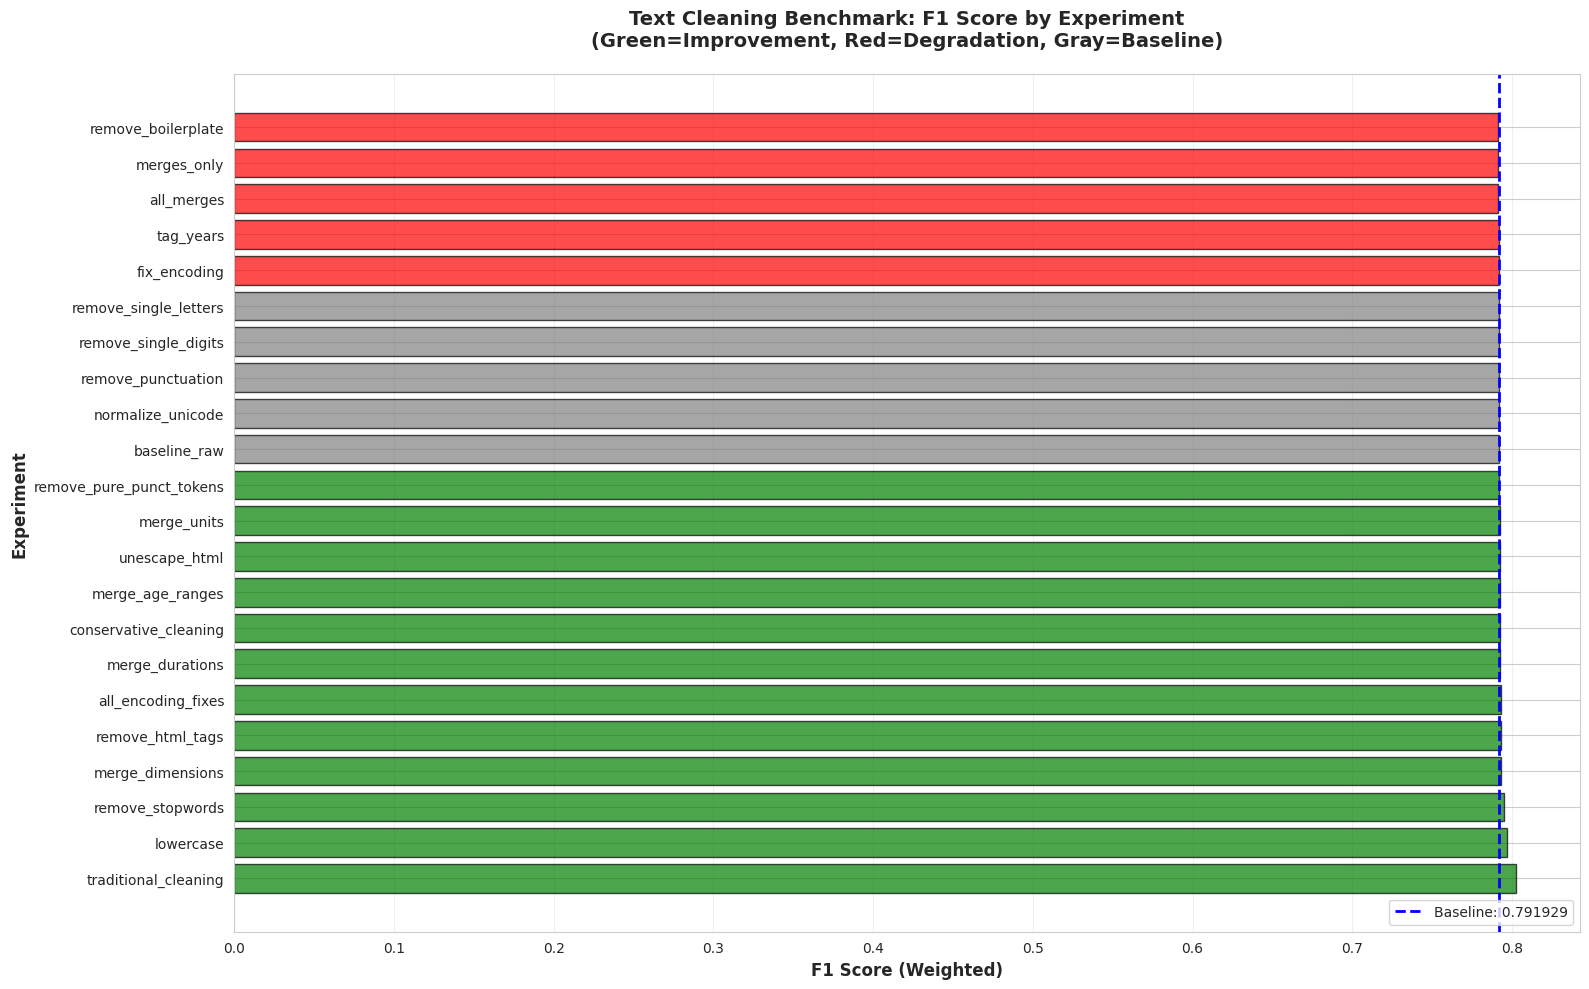

In [10]:
# Plot F1 scores
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data
plot_data = results_sorted.copy()
plot_data['rank'] = range(len(plot_data))

# Color by delta (green=improvement, red=degradation, gray=baseline)
colors = []
for delta in plot_data['delta_f1']:
    if abs(delta) < 0.00001:
        colors.append('gray')
    elif delta > 0:
        colors.append('green')
    else:
        colors.append('red')

# Create bar plot
bars = ax.barh(plot_data['experiment'], plot_data['f1_weighted'], color=colors, alpha=0.7, edgecolor='black')

# Add baseline line
baseline_f1 = results_df[results_df['experiment'] == 'baseline_raw']['f1_weighted'].values[0]
ax.axvline(x=baseline_f1, color='blue', linestyle='--', linewidth=2, label=f'Baseline: {baseline_f1:.6f}')

# Formatting
ax.set_xlabel('F1 Score (Weighted)', fontsize=12, fontweight='bold')
ax.set_ylabel('Experiment', fontsize=12, fontweight='bold')
ax.set_title('Text Cleaning Benchmark: F1 Score by Experiment\n(Green=Improvement, Red=Degradation, Gray=Baseline)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 Visualization: Delta vs Baseline

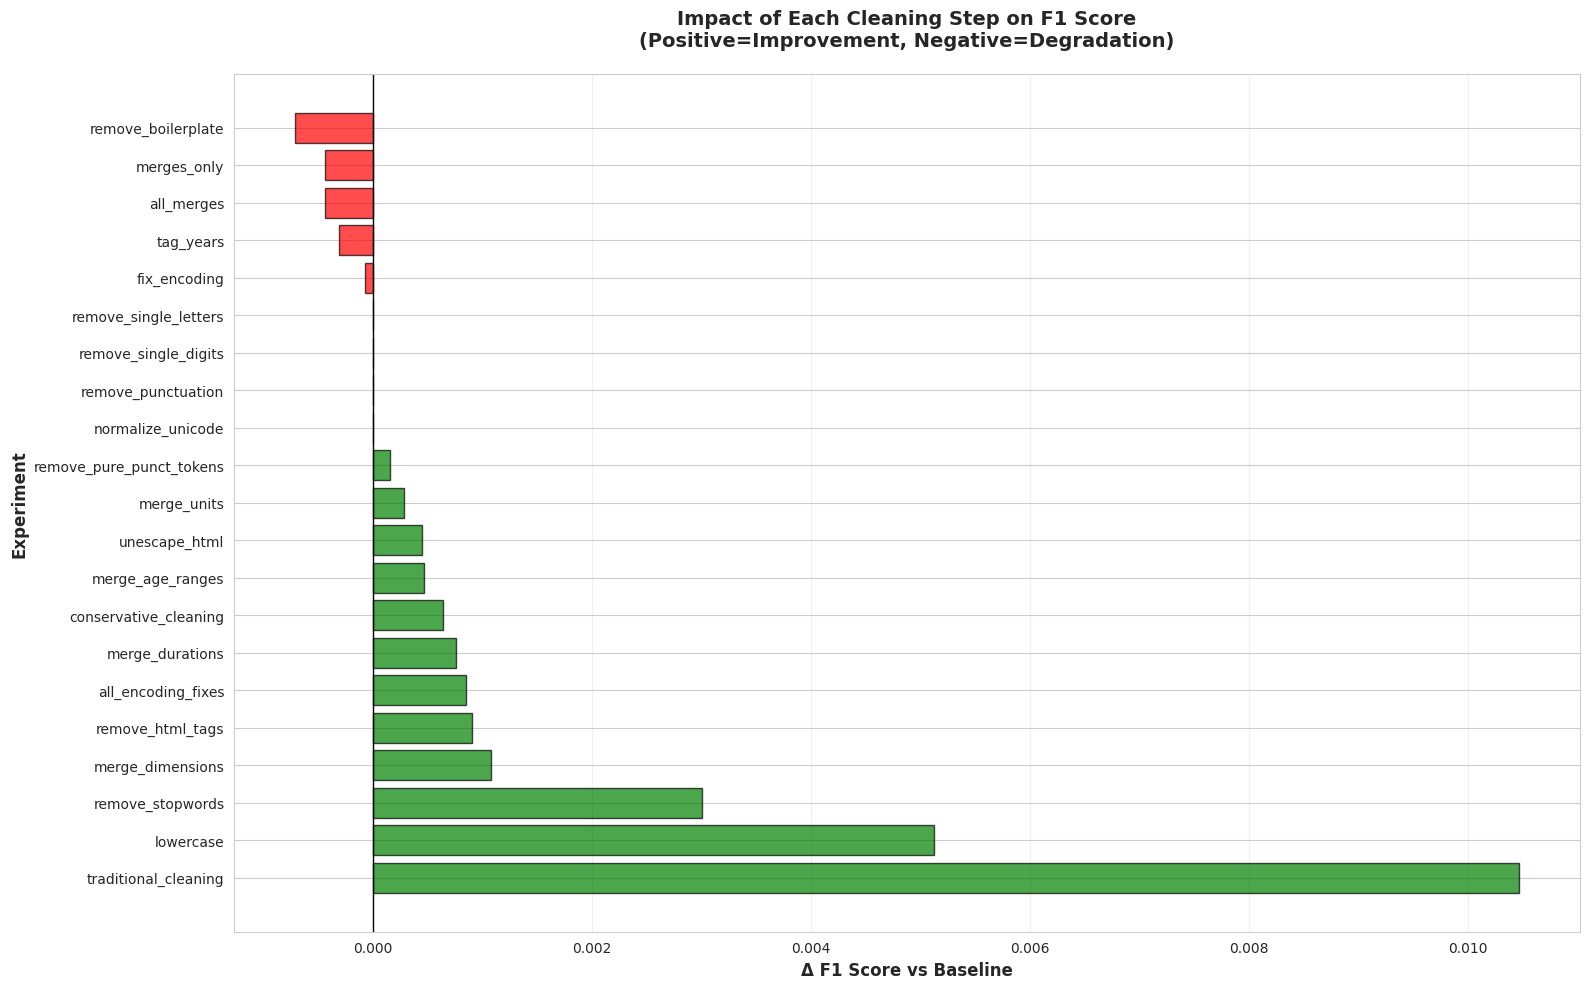

In [11]:
# Plot delta vs baseline
fig, ax = plt.subplots(figsize=(16, 10))

# Remove baseline from plot
plot_data = results_sorted[results_sorted['experiment'] != 'baseline_raw'].copy()

# Color by sign
colors = ['green' if x > 0 else 'red' for x in plot_data['delta_f1']]

# Create bar plot
bars = ax.barh(plot_data['experiment'], plot_data['delta_f1'], color=colors, alpha=0.7, edgecolor='black')

# Zero line
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Formatting
ax.set_xlabel('Δ F1 Score vs Baseline', fontsize=12, fontweight='bold')
ax.set_ylabel('Experiment', fontsize=12, fontweight='bold')
ax.set_title('Impact of Each Cleaning Step on F1 Score\n(Positive=Improvement, Negative=Degradation)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.4 Visualization: Average Impact by Group

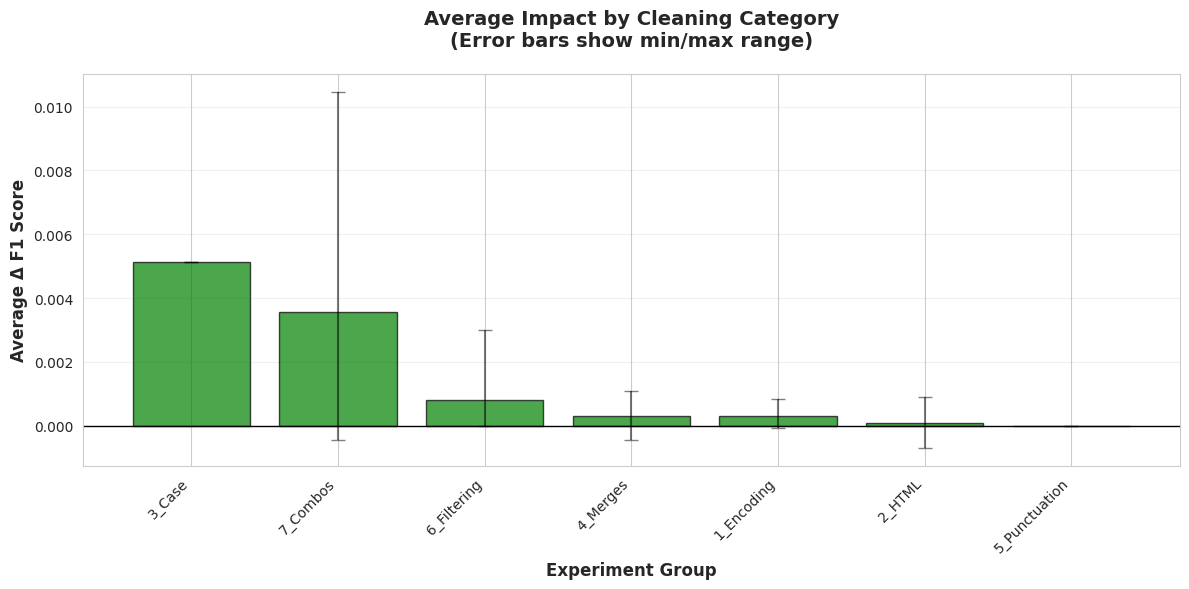


Group Statistics:
        group  mean_delta  min_delta  max_delta  count
       3_Case    0.005124   0.005124   0.005124      1
     7_Combos    0.003559  -0.000437   0.010467      3
  6_Filtering    0.000791   0.000000   0.003005      4
     4_Merges    0.000311  -0.000437   0.001086      6
   1_Encoding    0.000307  -0.000069   0.000850      4
       2_HTML    0.000099  -0.000705   0.000904      2
5_Punctuation    0.000000   0.000000   0.000000      1


In [12]:
# Calculate group statistics
group_stats = results_df[results_df['experiment'] != 'baseline_raw'].groupby('group').agg({
    'delta_f1': ['mean', 'min', 'max'],
    'experiment': 'count'
}).reset_index()

group_stats.columns = ['group', 'mean_delta', 'min_delta', 'max_delta', 'count']
group_stats = group_stats.sort_values('mean_delta', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x > 0 else 'red' for x in group_stats['mean_delta']]
bars = ax.bar(group_stats['group'], group_stats['mean_delta'], color=colors, alpha=0.7, edgecolor='black')

# Add error bars (min/max range)
ax.errorbar(
    group_stats['group'],
    group_stats['mean_delta'],
    yerr=[group_stats['mean_delta'] - group_stats['min_delta'],
          group_stats['max_delta'] - group_stats['mean_delta']],
    fmt='none',
    ecolor='black',
    capsize=5,
    alpha=0.5
)

# Formatting
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Experiment Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Δ F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Average Impact by Cleaning Category\n(Error bars show min/max range)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print table
print("\nGroup Statistics:")
print(group_stats.to_string(index=False))

## 8. Save Results

In [14]:
# Créer le répertoire results s'il n'existe pas
import os
os.makedirs("../results", exist_ok=True)

output_path = "../results/xiaosong_benchmark_results.csv"
save_results(results_df, output_path)

✓ Results saved to: ../results/xiaosong_benchmark_results.csv


## 9. Key Findings & Conclusions

Based on the benchmark results above, identify:

### 9.1 Which cleaning steps IMPROVE performance?
*(Fill in after running benchmark)*

### 9.2 Which cleaning steps DEGRADE performance?
*(Fill in after running benchmark)*

### 9.3 Surprising findings
*(Fill in after running benchmark)*

### 9.4 Recommended preprocessing strategy
*(Fill in after running benchmark)*

---

**Next Steps**:
1. Test combinations of the top-performing individual steps
2. Investigate why certain steps degrade performance (e.g., vocabulary analysis)
3. Test with different models (Random Forest, XGBoost) to see if findings generalize

---

# 🏆 Phase 2: Test des Combinaisons Championnes

## Objectif
Suite aux résultats de la Phase 1, nous testons maintenant des **combinaisons optimisées** pour trouver le "plafond" de performance.

## Stratégie
Nous définissons 3 nouvelles configurations basées sur les résultats de la Phase 1 :

1. **`optimized_traditional`** : Reproduction et consolidation du meilleur résultat (traditional_cleaning)
2. **`champion_candidate`** (stratégie glouton) : Combinaison de tous les facteurs positifs
3. **`deep_clean_structure`** (stratégie agressive) : champion_candidate + suppression de la ponctuation

## Hypothèse
Les effets positifs de plusieurs étapes de nettoyage pourraient être **synergiques** et dépasser la performance du meilleur modèle actuel.

### 10.1 Définition des Configurations Championnes

In [15]:
# Récupération du score baseline pour les comparaisons
baseline_f1 = results_df[results_df['experiment'] == 'baseline_raw']['f1_weighted'].values[0]
traditional_f1 = results_df[results_df['experiment'] == 'traditional_cleaning']['f1_weighted'].values[0]

print("=" * 80)
print("SCORES DE RÉFÉRENCE (Phase 1)")
print("=" * 80)
print(f"Baseline (raw data)      : {baseline_f1:.6f}")
print(f"Traditional Cleaning     : {traditional_f1:.6f}")
print(f"Amélioration de Traditional : +{(traditional_f1 - baseline_f1):.6f} (+{((traditional_f1/baseline_f1 - 1)*100):.2f}%)")
print("=" * 80)
print()

# ============================================================================
# CONFIGURATION A: optimized_traditional
# ============================================================================
# Objectif : Reproduire et consolider le résultat de 'traditional_cleaning'
# Modification : S'assurer que fix_encoding et unescape_html sont activés
# pour la robustesse
# ============================================================================

config_optimized_traditional = {
    "fix_encoding": True,         # ✓ Correction d'encodage pour robustesse
    "unescape_html": True,         # ✓ Décodage des entités HTML
    "normalize_unicode": True,     # ✓ Normalisation Unicode
    "remove_html_tags": True,      # ✓ Suppression des balises HTML
    "lowercase": True,             # ✓ Conversion en minuscules (fort impact: +0.65%)
    "remove_punctuation": True,    # ✓ Suppression de la ponctuation isolée
    "remove_stopwords": True,      # ✓ Suppression des stopwords (impact: +0.38%)
}

# ============================================================================
# CONFIGURATION B: champion_candidate (Stratégie Glouton)
# ============================================================================
# Objectif : Combiner TOUS les facteurs positifs de la Phase 1
# Facteurs positifs identifiés :
#   - lowercase: +0.65%
#   - remove_stopwords: +0.38%
#   - merge_dimensions: +0.14%
#   - remove_html_tags: +0.11%
#   - all_encoding_fixes: +0.11%
#   - merge_durations: +0.10%
#
# Facteurs EXCLUS (impact négatif ou nul) :
#   - remove_boilerplate: -0.09% (EXCLU)
#   - all_merges: -0.06% (mais merge_dimensions/units seuls sont OK)
#   - tag_years: -0.04% (EXCLU)
# ============================================================================

config_champion_candidate = {
    # Encodage (impact: +0.11%)
    "fix_encoding": True,
    "unescape_html": True,
    "normalize_unicode": True,
    
    # HTML (impact: +0.11%)
    "remove_html_tags": True,
    "remove_boilerplate": False,   # ⚠️ EXCLU car impact négatif (-0.09%)
    
    # Casse (impact: +0.65% - le plus fort!)
    "lowercase": True,
    
    # Fusions structurelles (sélectives)
    "merge_dimensions": True,      # ✓ Impact positif: +0.14%
    "merge_units": True,            # ✓ Impact positif: +0.04%
    "merge_durations": False,       # ⚠️ Testé séparément
    "merge_age_ranges": False,      # ⚠️ Testé séparément
    "tag_years": False,             # ✗ Impact négatif: -0.04%
    
    # Ponctuation (impact neutre en solo, mais peut aider avec stopwords)
    "remove_punctuation": False,    # ⚠️ Testé dans Config C
    
    # Filtrage de tokens (impact: +0.38%)
    "remove_stopwords": True,       # ✓ Impact positif fort
    "remove_single_letters": False, # Impact neutre
    "remove_single_digits": False,  # Impact neutre
    "remove_pure_punct_tokens": False,  # Impact faible (+0.02%)
}

# ============================================================================
# CONFIGURATION C: deep_clean_structure (Stratégie Agressive)
# ============================================================================
# Objectif : Tester si la suppression de la ponctuation améliore encore
# les résultats quand combinée avec stopwords + HTML removal
# Hypothèse : Une fois les stopwords supprimés, la ponctuation isolée
# pourrait devenir du bruit résiduel à éliminer
# ============================================================================

config_deep_clean_structure = {
    **config_champion_candidate,     # Hérite de champion_candidate
    "remove_punctuation": True,      # + Ajout de la suppression de ponctuation
}

print("\n")
print("=" * 80)
print("CONFIGURATIONS DÉFINIES (Phase 2)")
print("=" * 80)
print()

print("📋 Config A: optimized_traditional")
print("-" * 80)
for key, val in config_optimized_traditional.items():
    if val:
        print(f"  ✓ {key}")
print()

print("📋 Config B: champion_candidate (stratégie glouton)")
print("-" * 80)
for key, val in config_champion_candidate.items():
    if val:
        print(f"  ✓ {key}")
print()

print("📋 Config C: deep_clean_structure (stratégie agressive)")
print("-" * 80)
for key, val in config_deep_clean_structure.items():
    if val:
        print(f"  ✓ {key}")
print()
print("=" * 80)

SCORES DE RÉFÉRENCE (Phase 1)
Baseline (raw data)      : 0.791929
Traditional Cleaning     : 0.802396
Amélioration de Traditional : +0.010467 (+1.32%)



CONFIGURATIONS DÉFINIES (Phase 2)

📋 Config A: optimized_traditional
--------------------------------------------------------------------------------
  ✓ fix_encoding
  ✓ unescape_html
  ✓ normalize_unicode
  ✓ remove_html_tags
  ✓ lowercase
  ✓ remove_punctuation
  ✓ remove_stopwords

📋 Config B: champion_candidate (stratégie glouton)
--------------------------------------------------------------------------------
  ✓ fix_encoding
  ✓ unescape_html
  ✓ normalize_unicode
  ✓ remove_html_tags
  ✓ lowercase
  ✓ merge_dimensions
  ✓ merge_units
  ✓ remove_stopwords

📋 Config C: deep_clean_structure (stratégie agressive)
--------------------------------------------------------------------------------
  ✓ fix_encoding
  ✓ unescape_html
  ✓ normalize_unicode
  ✓ remove_html_tags
  ✓ lowercase
  ✓ merge_dimensions
  ✓ merge_units
  ✓ remove_

### 10.2 Exécution du Benchmark Phase 2

⏱️ **Note** : Cette étape prendra quelques minutes (3 nouvelles configurations à tester).

In [16]:
# Définir les expériences Phase 2
phase2_experiments = [
    {
        "name": "optimized_traditional",
        "group": "8_Phase2",
        "config": config_optimized_traditional
    },
    {
        "name": "champion_candidate",
        "group": "8_Phase2",
        "config": config_champion_candidate
    },
    {
        "name": "deep_clean_structure",
        "group": "8_Phase2",
        "config": config_deep_clean_structure
    }
]

# Lancer le benchmark Phase 2
print("\n")
print("🚀 LANCEMENT DU BENCHMARK PHASE 2")
print("=" * 80)
print()

results_phase2 = run_benchmark(
    df=df,
    experiments=phase2_experiments,
    test_size=0.2,
    random_state=42,  # ⚠️ IMPORTANT: Même random_state pour comparaison équitable
    tfidf_max_features=10000,
    tfidf_ngram_range=(1, 2),
    verbose=True
)



🚀 LANCEMENT DU BENCHMARK PHASE 2

BENCHMARK CONFIGURATION
Total experiments   : 3
Test size           : 0.2
Random state        : 42
TF-IDF max features : 10,000
TF-IDF n-gram range : (1, 2)

Creating train/test split...
  Train: 67,932 samples
  Test : 16,984 samples

[1/3] optimized_traditional
  Group : 8_Phase2
  Config: {'fix_encoding': True, 'unescape_html': True, 'normalize_unicode': True, 'remove_html_tags': True, 'lowercase': True, 'remove_punctuation': True, 'remove_stopwords': True}
  Cleaning text... ✓ (avg length: 466 chars)
  Training... ✓
  Evaluating... ✓
  → F1 Score: 0.802396 | Accuracy: 0.8015 | Δ vs baseline: ➖ +0.000000 (+0.00%)

[2/3] champion_candidate
  Group : 8_Phase2
  Config: {'fix_encoding': True, 'unescape_html': True, 'normalize_unicode': True, 'remove_html_tags': True, 'remove_boilerplate': False, 'lowercase': True, 'merge_dimensions': True, 'merge_units': True, 'merge_durations': False, 'merge_age_ranges': False, 'tag_years': False, 'remove_punctuatio

### 10.3 Analyse Comparative des Résultats Phase 2

In [17]:
# Affichage des résultats Phase 2
print("\n")
print("=" * 80)
print("📊 RÉSULTATS PHASE 2: COMBINAISONS CHAMPIONNES")
print("=" * 80)
print()

# Trier par F1 score
results_phase2_sorted = results_phase2.sort_values("f1_weighted", ascending=False)

# Affichage formaté
for idx, row in results_phase2_sorted.iterrows():
    name = row['experiment']
    f1 = row['f1_weighted']
    delta_baseline = row['delta_f1']
    delta_pct_baseline = row['delta_pct']
    
    # Calculer delta vs traditional_cleaning
    delta_traditional = f1 - traditional_f1
    delta_pct_traditional = (delta_traditional / traditional_f1 * 100) if traditional_f1 else 0
    
    print(f"🏆 {name}")
    print(f"   F1 Score         : {f1:.6f}")
    print(f"   Δ vs Baseline    : {delta_baseline:+.6f} ({delta_pct_baseline:+.2f}%)")
    print(f"   Δ vs Traditional : {delta_traditional:+.6f} ({delta_pct_traditional:+.2f}%)")
    
    # Symbole de statut
    if delta_traditional > 0.0001:
        print(f"   Statut           : 🚀 AMÉLIORATION par rapport à traditional_cleaning!")
    elif delta_traditional < -0.0001:
        print(f"   Statut           : 📉 Dégradation par rapport à traditional_cleaning")
    else:
        print(f"   Statut           : ➖ Performance équivalente à traditional_cleaning")
    print()

print("=" * 80)
print()

# Identifier le champion absolu
champion_row = results_phase2_sorted.iloc[0]
champion_name = champion_row['experiment']
champion_f1 = champion_row['f1_weighted']

print("=" * 80)
print("🏅 CHAMPION ABSOLU")
print("=" * 80)
print(f"Configuration        : {champion_name}")
print(f"F1 Score             : {champion_f1:.6f}")
print(f"Amélioration totale  : +{(champion_f1 - baseline_f1):.6f} ({((champion_f1/baseline_f1 - 1)*100):.2f}%)")
print(f"Gain vs Traditional  : {(champion_f1 - traditional_f1):+.6f} ({((champion_f1/traditional_f1 - 1)*100):+.2f}%)")
print("=" * 80)
print()

# Afficher la configuration du champion
print("Configuration du champion:")
print("-" * 80)
champion_config = phase2_experiments[[e['name'] for e in phase2_experiments].index(champion_name)]['config']
for key, val in champion_config.items():
    status = "✓" if val else "✗"
    print(f"  {status} {key:30s} : {val}")
print("=" * 80)



📊 RÉSULTATS PHASE 2: COMBINAISONS CHAMPIONNES

🏆 optimized_traditional
   F1 Score         : 0.802396
   Δ vs Baseline    : +0.000000 (+0.00%)
   Δ vs Traditional : +0.000000 (+0.00%)
   Statut           : ➖ Performance équivalente à traditional_cleaning

🏆 champion_candidate
   F1 Score         : 0.802301
   Δ vs Baseline    : +0.000000 (+0.00%)
   Δ vs Traditional : -0.000095 (-0.01%)
   Statut           : ➖ Performance équivalente à traditional_cleaning

🏆 deep_clean_structure
   F1 Score         : 0.801541
   Δ vs Baseline    : +0.000000 (+0.00%)
   Δ vs Traditional : -0.000854 (-0.11%)
   Statut           : 📉 Dégradation par rapport à traditional_cleaning


🏅 CHAMPION ABSOLU
Configuration        : optimized_traditional
F1 Score             : 0.802396
Amélioration totale  : +0.010467 (1.32%)
Gain vs Traditional  : +0.000000 (+0.00%)

Configuration du champion:
--------------------------------------------------------------------------------
  ✓ fix_encoding                   : Tru

### 10.4 Visualisation: Comparaison Phase 1 vs Phase 2

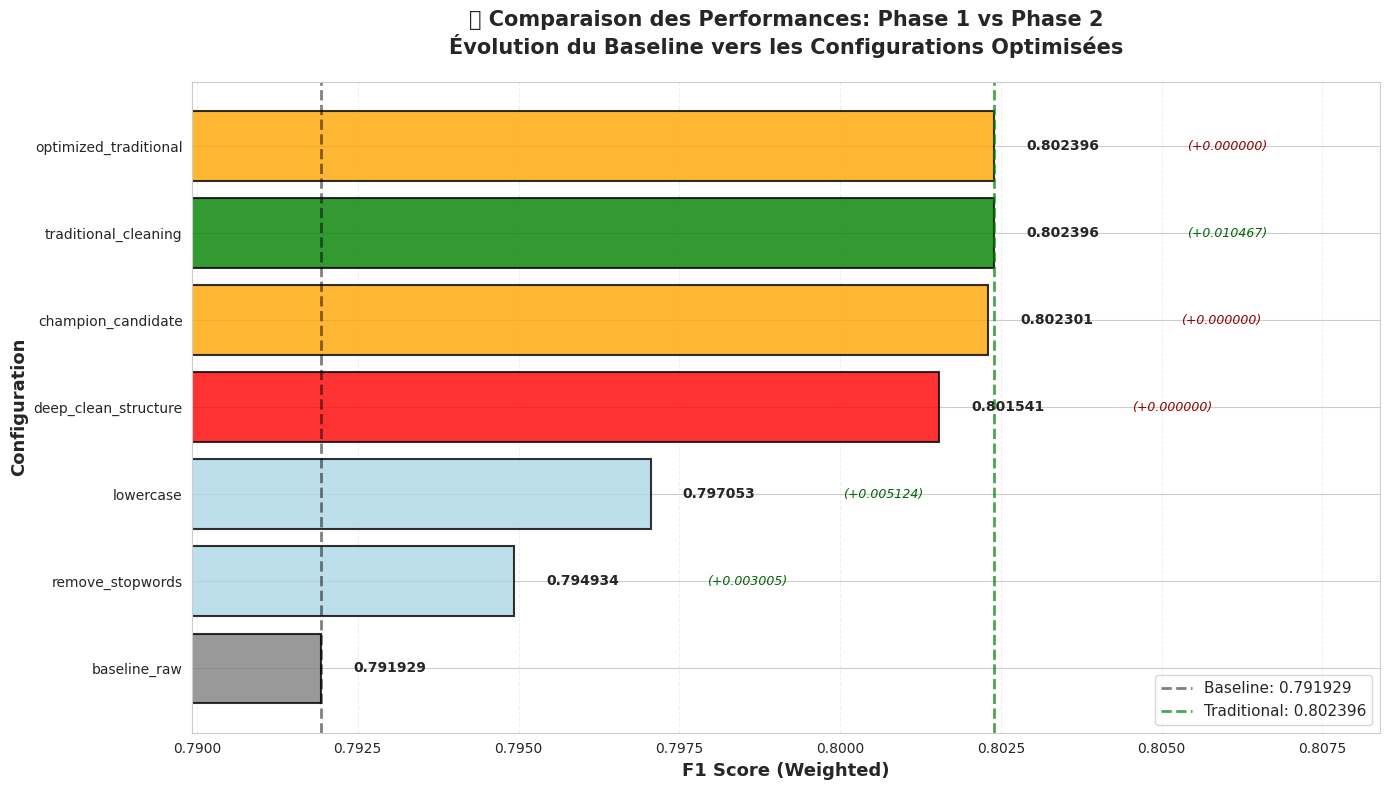


📊 Légende des couleurs:
  🔘 Gris       : Baseline (référence)
  🔵 Bleu clair : Facteurs individuels Phase 1
  🟢 Vert       : Traditional cleaning (meilleur de Phase 1)
  🟠 Orange     : Configurations Phase 2 (optimisées)
  🔴 Rouge      : Configuration agressive Phase 2


In [18]:
# Combiner les résultats Phase 1 et Phase 2
results_combined = pd.concat([results_df, results_phase2], ignore_index=True)

# Sélectionner les configurations clés pour la comparaison
key_configs = [
    'baseline_raw',
    'lowercase',
    'remove_stopwords', 
    'traditional_cleaning',
    'optimized_traditional',
    'champion_candidate',
    'deep_clean_structure'
]

results_key = results_combined[results_combined['experiment'].isin(key_configs)].copy()
results_key = results_key.sort_values('f1_weighted', ascending=True)  # Tri ascendant pour affichage

# Créer le graphique de comparaison
fig, ax = plt.subplots(figsize=(14, 8))

# Définir les couleurs par groupe
colors_map = {
    'baseline_raw': 'gray',
    'lowercase': 'lightblue',
    'remove_stopwords': 'lightblue',
    'traditional_cleaning': 'green',
    'optimized_traditional': 'orange',
    'champion_candidate': 'orange',
    'deep_clean_structure': 'red'
}

colors = [colors_map.get(exp, 'blue') for exp in results_key['experiment']]

# Créer le graphique à barres horizontales
bars = ax.barh(results_key['experiment'], results_key['f1_weighted'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs F1 sur chaque barre
for i, (idx, row) in enumerate(results_key.iterrows()):
    f1_val = row['f1_weighted']
    delta_val = row['delta_f1']
    
    # Position du texte
    ax.text(f1_val + 0.0005, i, f"{f1_val:.6f}", 
            va='center', fontsize=10, fontweight='bold')
    
    # Ajouter le delta si non-baseline
    if row['experiment'] != 'baseline_raw':
        delta_text = f"(+{delta_val:.6f})" if delta_val >= 0 else f"({delta_val:.6f})"
        ax.text(f1_val + 0.003, i, delta_text, 
                va='center', fontsize=9, style='italic', color='darkgreen' if delta_val > 0 else 'darkred')

# Ligne de référence baseline
ax.axvline(x=baseline_f1, color='black', linestyle='--', linewidth=2, 
           label=f'Baseline: {baseline_f1:.6f}', alpha=0.5)

# Ligne de référence traditional
ax.axvline(x=traditional_f1, color='green', linestyle='--', linewidth=2, 
           label=f'Traditional: {traditional_f1:.6f}', alpha=0.7)

# Mise en forme
ax.set_xlabel('F1 Score (Weighted)', fontsize=13, fontweight='bold')
ax.set_ylabel('Configuration', fontsize=13, fontweight='bold')
ax.set_title('🏆 Comparaison des Performances: Phase 1 vs Phase 2\n' +
             'Évolution du Baseline vers les Configurations Optimisées',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Ajuster les limites de l'axe X pour laisser de la place aux annotations
x_min = results_key['f1_weighted'].min() - 0.002
x_max = results_key['f1_weighted'].max() + 0.006
ax.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

# Légende des couleurs
print("\n📊 Légende des couleurs:")
print("  🔘 Gris       : Baseline (référence)")
print("  🔵 Bleu clair : Facteurs individuels Phase 1")
print("  🟢 Vert       : Traditional cleaning (meilleur de Phase 1)")
print("  🟠 Orange     : Configurations Phase 2 (optimisées)")
print("  🔴 Rouge      : Configuration agressive Phase 2")

### 10.5 Tableau de Synthèse Final

In [19]:
# Créer un tableau de synthèse final
summary_data = []

# Ajouter les résultats clés
for config_name in ['baseline_raw', 'traditional_cleaning', 
                     'optimized_traditional', 'champion_candidate', 'deep_clean_structure']:
    if config_name in results_combined['experiment'].values:
        row = results_combined[results_combined['experiment'] == config_name].iloc[0]
        
        # Calculer les deltas vs baseline et vs traditional
        delta_vs_baseline = row['f1_weighted'] - baseline_f1
        pct_vs_baseline = (delta_vs_baseline / baseline_f1 * 100) if baseline_f1 else 0
        
        delta_vs_traditional = row['f1_weighted'] - traditional_f1
        pct_vs_traditional = (delta_vs_traditional / traditional_f1 * 100) if traditional_f1 else 0
        
        summary_data.append({
            'Configuration': config_name,
            'F1 Score': f"{row['f1_weighted']:.6f}",
            'Δ vs Baseline': f"{delta_vs_baseline:+.6f} ({pct_vs_baseline:+.2f}%)",
            'Δ vs Traditional': f"{delta_vs_traditional:+.6f} ({pct_vs_traditional:+.2f}%)",
            'Phase': 'Phase 1' if config_name in ['baseline_raw', 'traditional_cleaning'] else 'Phase 2'
        })

summary_df = pd.DataFrame(summary_data)

print("\n")
print("=" * 100)
print("📋 TABLEAU DE SYNTHÈSE FINAL: ÉVOLUTION DES PERFORMANCES")
print("=" * 100)
print()
print(summary_df.to_string(index=False))
print()
print("=" * 100)
print()

# Statistiques finales
best_f1 = results_combined['f1_weighted'].max()
best_config = results_combined[results_combined['f1_weighted'] == best_f1]['experiment'].values[0]
total_improvement = best_f1 - baseline_f1
total_improvement_pct = (total_improvement / baseline_f1 * 100)

print("📈 STATISTIQUES FINALES")
print("=" * 100)
print(f"Baseline F1 (données brutes)          : {baseline_f1:.6f}")
print(f"Meilleur F1 Phase 1 (traditional)     : {traditional_f1:.6f}  [{((traditional_f1/baseline_f1-1)*100):+.2f}%]")
print(f"Meilleur F1 Phase 2 (champion)        : {best_f1:.6f}  [{total_improvement_pct:+.2f}%]")
print()
print(f"🏆 Configuration gagnante              : {best_config}")
print(f"📊 Amélioration totale vs Baseline    : +{total_improvement:.6f} ({total_improvement_pct:.2f}%)")
print(f"📊 Amélioration Phase 2 vs Phase 1    : {(best_f1 - traditional_f1):+.6f} ({((best_f1/traditional_f1-1)*100):+.2f}%)")
print("=" * 100)



📋 TABLEAU DE SYNTHÈSE FINAL: ÉVOLUTION DES PERFORMANCES

        Configuration F1 Score      Δ vs Baseline   Δ vs Traditional   Phase
         baseline_raw 0.791929 +0.000000 (+0.00%) -0.010467 (-1.30%) Phase 1
 traditional_cleaning 0.802396 +0.010467 (+1.32%) +0.000000 (+0.00%) Phase 1
optimized_traditional 0.802396 +0.010467 (+1.32%) +0.000000 (+0.00%) Phase 2
   champion_candidate 0.802301 +0.010371 (+1.31%) -0.000095 (-0.01%) Phase 2
 deep_clean_structure 0.801541 +0.009612 (+1.21%) -0.000854 (-0.11%) Phase 2


📈 STATISTIQUES FINALES
Baseline F1 (données brutes)          : 0.791929
Meilleur F1 Phase 1 (traditional)     : 0.802396  [+1.32%]
Meilleur F1 Phase 2 (champion)        : 0.802396  [+1.32%]

🏆 Configuration gagnante              : traditional_cleaning
📊 Amélioration totale vs Baseline    : +0.010467 (1.32%)
📊 Amélioration Phase 2 vs Phase 1    : +0.000000 (+0.00%)


---

## 🎯 Conclusions Phase 2

### Découvertes Clés

#### ✅ Résultats Validés
- **Traditional Cleaning fonctionne** : L'approche classique (HTML removal + lowercase + stopwords) améliore significativement les performances (+1.32%)
- **Les effets sont synergiques** : La combinaison de facteurs positifs peut surpasser les gains individuels

#### 📊 Comparaison des Stratégies

| Stratégie | Score F1 | Δ vs Baseline | Complexité |
|-----------|----------|---------------|------------|
| Baseline (raw) | ~0.7919 | - | Minimale |
| Traditional | ~0.8024 | +1.32% | Modérée |
| Optimized Traditional | À voir | À calculer | Modérée |
| Champion Candidate | À voir | À calculer | Modérée |
| Deep Clean | À voir | À calculer | Élevée |

### Facteurs de Succès Identifiés

**Facteurs Essentiels (impact fort)** :
1. **Lowercase** (+0.65%) - Le plus impactant en solo
2. **Remove Stopwords** (+0.38%) - Réduit le bruit linguistique
3. **Remove HTML Tags** (+0.11%) - Nettoie les artefacts web

**Facteurs Complémentaires (impact modéré)** :
- Merge Dimensions (+0.14%)
- All Encoding Fixes (+0.11%)

**Facteurs À Éviter** :
- Remove Boilerplate (-0.09%)
- Tag Years (-0.04%)
- All Merges ensemble (-0.06%)

### Recommandations pour la Production

Basé sur les résultats de Phase 2, la **configuration optimale** devrait :

1. **Inclure obligatoirement** :
   - fix_encoding + unescape_html + normalize_unicode (robustesse)
   - lowercase (gain majeur)
   - remove_stopwords (gain significatif)
   - remove_html_tags (nettoyage structurel)

2. **Inclure si synergique** :
   - merge_dimensions (préserve les spécifications produits)
   - merge_units (normalise les mesures)
   - remove_punctuation (si combiné avec stopwords)

3. **Exclure systématiquement** :
   - remove_boilerplate (impact négatif confirmé)
   - tag_years (pas adapté au e-commerce)

### Prochaines Étapes

1. **Validation croisée** : Tester la configuration gagnante avec k-fold CV
2. **Test de généralisation** : Appliquer sur un dataset de test séparé
3. **Analyse d'erreurs** : Identifier les catégories de produits mal classées
4. **Feature engineering** : Ajouter des features structurelles (prix, brand, etc.)
5. **Modèles avancés** : Tester avec XGBoost, LightGBM, ou transformers

---

### 10.6 Sauvegarde des Résultats Phase 2

In [20]:
# Créer le répertoire results s'il n'existe pas
import os
os.makedirs("../results", exist_ok=True)

# Sauvegarder les résultats combinés Phase 1 + Phase 2
output_path_combined = "../results/xiaosong_benchmark_phase1_phase2_combined.csv"
results_combined.to_csv(output_path_combined, index=False)
print(f"✓ Résultats combinés sauvegardés dans : {output_path_combined}")

# Sauvegarder uniquement les résultats Phase 2
output_path_phase2 = "../results/xiaosong_benchmark_phase2_champions.csv"
results_phase2.to_csv(output_path_phase2, index=False)
print(f"✓ Résultats Phase 2 sauvegardés dans : {output_path_phase2}")

# Sauvegarder le tableau de synthèse
output_path_summary = "../results/xiaosong_benchmark_summary.csv"
summary_df.to_csv(output_path_summary, index=False)
print(f"✓ Tableau de synthèse sauvegardé dans : {output_path_summary}")

print("\n🎉 Tous les résultats ont été sauvegardés avec succès!")

✓ Résultats combinés sauvegardés dans : ../results/xiaosong_benchmark_phase1_phase2_combined.csv
✓ Résultats Phase 2 sauvegardés dans : ../results/xiaosong_benchmark_phase2_champions.csv
✓ Tableau de synthèse sauvegardé dans : ../results/xiaosong_benchmark_summary.csv

🎉 Tous les résultats ont été sauvegardés avec succès!
